# Solution for the first science case

In [58]:
#########################################
# Author: Eduardo Alberto Duarte Lacerda
# E-mail: dhubax@gmail.com
#########################################

# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt

## Read catalogs using LSDB

### Start Dask client

In [2]:
# Start a Dask client for the parallel process used by lsdb
max_cpu = 8
max_mem = '6GB'
client = Client(n_workers=max_cpu, memory_limit=max_mem)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39903,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:34347,Total threads: 2
Dashboard: http://127.0.0.1:32775/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:43965,


## S-PLUS Catalogs choice

In [59]:
# search for the full S-PLUS DR4/dual mode catalog
dr4psf_search = splusdata.get_hipscats('dr4/psf')

# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4psf_search}')

# select the first catalog found
dr4psf_hipscat, dr4psf_margin_cache_hipscat = dr4psf_search[0]

# Create the columns list to retrieve only necessaries columns
'''/
We use here choose the magnitudes from 'psf' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'RA', 'DEC'] 

apperture = 'psf'
bands = ['g', 'r', 'i']
columns += [f'{b}_{apperture}' for b in bands] 
columns += [f's2n_{b}_{apperture}' for b in bands]
columns += [f'CLASS_STAR_{b}' for b in bands]

# Select only stars 
filters = [(f'CLASS_STAR_{b}', '=', 1) for b in bands]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/psf/', 'https://splus.cloud/HIPS/catalogs/dr4/psf_2arcsec/']]


### Read DR4/dual and QSO/star/galaxy catalogs

In [60]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4psf_margin = lsdb.read_hipscat(dr4psf_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4psf = lsdb.read_hipscat(
    dr4psf_hipscat,
    margin_cache=dr4psf_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    filters=filters,
)

# GAIA DR3 HiPSCat
gaia = lsdb.read_hipscat(
    'https://data.lsdb.io/unstable/gaia_dr3/gaia/',
    margin_cache='https://data.lsdb.io/unstable/gaia_dr3/gaia_10arcs/',
    columns=[
        'source_id',
        'ra',
        'dec',
        'parallax',
        'parallax_error',
        'pmra',
        'pmdec',
        #'pmra_error',
        #'pmdec_error',
        #'radial_velocity',
        #'radial_velocity_error', 
        #'ruwe',
    ],
)

## Perform the crossmatch

In [61]:
dr4psfgaia_crosmatch = dr4psf.crossmatch(gaia, suffixes=['_dr4', '_gaia'], radius_arcsec=1)

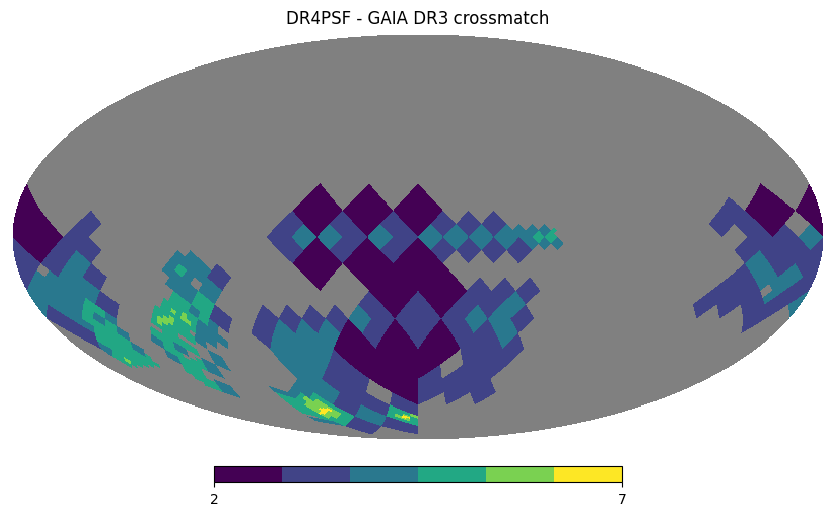

In [62]:
dr4psfgaia_crosmatch.plot_pixels('DR4PSF - GAIA DR3 crossmatch')

## Search for objects using the crossmatch result table

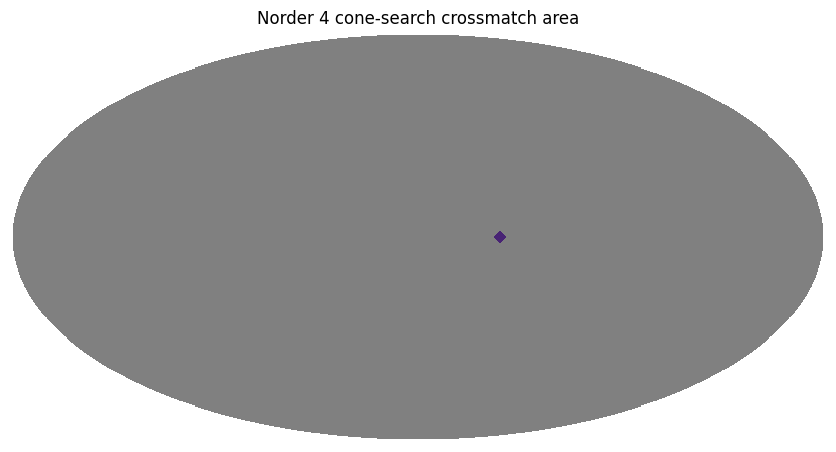

In [63]:
# Let's get the resultant table:
cone_center_coord = (323.36249, -0.82333) # RA and DEC in degrees
cone_radius = 30*60 # arcsec
objects_table_crossmatch = dr4psfgaia_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius)
#objects_table_crossmatch = dr4dualsqg_crosmatch.box_search([323, 324], [-1.3, -0.5])
objects_table_crossmatch.plot_pixels('cone-search crossmatch area')

In [64]:
objects_table = objects_table_crossmatch.compute()

<hr>

## Create plots

###  Selection of objects

In [66]:
# M2 Selection of pixels
# Messier 2 proper motion mask (cluster selection using GAIA DR3 proper motion)
pmra, pmdec = 3.5, -2.15  # mas/yr
M2_distance_pc = 11500
M2_mask = objects_table['pmra_gaia'] > (pmra - 0.5)
M2_mask = np.bitwise_and(M2_mask, objects_table['pmra_gaia'] < (pmra + 0.5))
M2_mask = np.bitwise_and(M2_mask, objects_table['pmdec_gaia'] > (pmdec - 0.5))
M2_mask = np.bitwise_and(M2_mask, objects_table['pmdec_gaia'] < (pmdec + 0.5))
M2_mabs_corr = - 5*np.log10(M2_distance_pc) + 5

# field stars
# Using GAIA DR3 paralaxes for distance calc.
distance_pc = 1/(0.001*objects_table['parallax_gaia'])
epar = objects_table['parallax_error_gaia']
mask = (epar < 0.2)
mabs_corr = - 5*np.log10(distance_pc) + 5

# Quality control
suffix = '_dr4'

# quality mask
# Keep S/N between 30 and 1000
QC_mask = objects_table[f's2n_g_{apperture}{suffix}'] > 30
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_g_{apperture}{suffix}'] < 1000)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_g_{apperture}{suffix}'] != 99)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] > 30)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] < 1000)
QC_mask = np.bitwise_and(QC_mask, objects_table[f's2n_i_{apperture}{suffix}'] != 99)
# keep r magnitudes between 14 an 19
QC_mask = np.bitwise_and(QC_mask, objects_table[f'r_{apperture}{suffix}'] > 14)
QC_mask = np.bitwise_and(QC_mask, objects_table[f'r_{apperture}{suffix}'] < 19)

mask = np.bitwise_and(mask, QC_mask)
M2_mask = np.bitwise_and(M2_mask, QC_mask)

/home/lacerda/.pyenv/versions/dev/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)


## RA and DEC distribution

Text(0.5, 0, 'DEC')

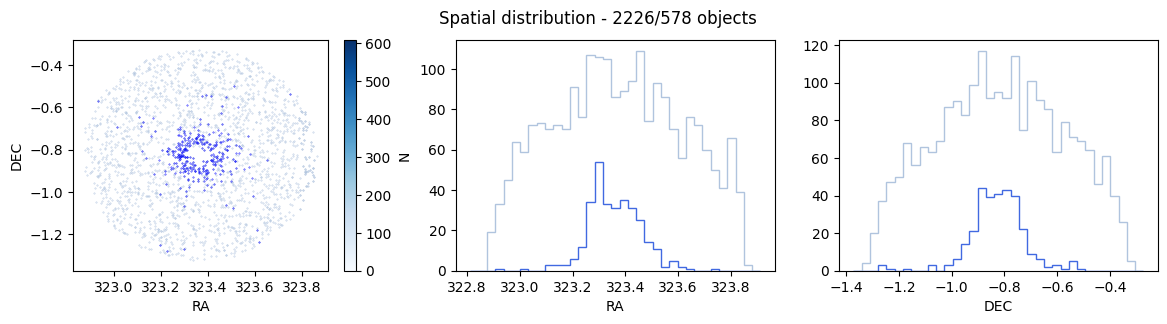

In [67]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(14, 3)
N = mask.sum()
N_M2 = maskm2.sum()
f.suptitle(f'Spatial distribution - {N}/{N_M2} objects')
ra = objects_table['RA_dr4']
dec = objects_table['DEC_dr4']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.1*x, 1.1*x])
dec_range = cone_center_coord[1]+np.array([-1.1*x, 1.1*x])
im = ax1.scatter(ra[mask], dec[mask], c='lightsteelblue', s=0.1)
im = ax1.scatter(ra[M2_mask], dec[M2_mask], c='b', s=0.1)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
cax = plt.colorbar(im1, ax=ax1)
cax.ax.set_ylabel('N')
ax2.hist([ra[mask], ra[M2_mask]], bins=35, range=ra_range, density=False, color=['lightsteelblue', 'royalblue'], histtype='step')
ax2.set_xlabel('RA')
ax3.hist([dec[mask], dec[M2_mask]], bins=35, range=dec_range, density=False, color=['lightsteelblue', 'royalblue'], histtype='step')
ax3.set_xlabel('DEC')

## H.R. Diagrams 

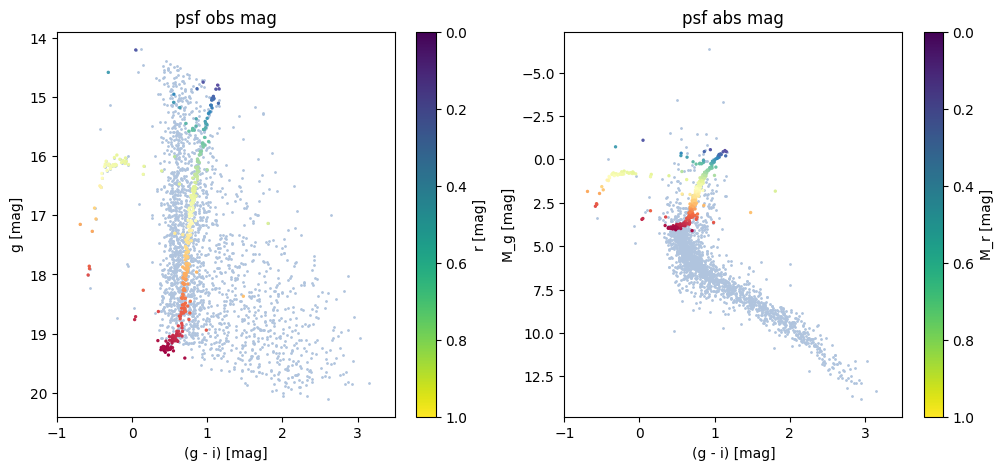

In [70]:
x = objects_table[f'g_{apperture}{suffix}'] - objects_table[f'i_{apperture}{suffix}']
y = objects_table[f'g_{apperture}{suffix}']
z = objects_table[f'r_{apperture}{suffix}']

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(12, 5)
im = ax1.scatter(x[mask], y[mask], s=1, c='lightsteelblue')
ax1.scatter(x[M2_mask], y[M2_mask], c=z[M2_mask], s=2, cmap='Spectral_r')
ax1.set_title(f'{apperture} obs mag')
cax = plt.colorbar(im, ax=ax1)
cax.ax.set_ylabel('r [mag]')
cax.ax.invert_yaxis()
ax1.set_xlabel(f'(g - i) [mag]')
ax1.set_ylabel(f'g [mag]')
ax1.set_xlim(-1, 3.5)
ax1.invert_yaxis()

# field stars
Y = y + mabs_corr
# Messier 2 stars
M2_Y = y + M2_mabs_corr
M2_Z = z + M2_mabs_corr

im = ax2.scatter(x[mask & ~M2_mask], Y[mask & ~M2_mask], s=1, c='lightsteelblue')
ax2.scatter(x[M2_mask], M2_Y[M2_mask], c=M2_Z[M2_mask], s=2, cmap='Spectral_r')
ax2.set_title(f'{apperture} abs mag')
cax = plt.colorbar(im, ax=ax2)
cax.ax.set_ylabel('M_r [mag]')
cax.ax.invert_yaxis()
ax2.set_xlabel(f'(g - i) [mag]')
ax2.set_ylabel(f'M_g [mag]')
ax2.set_xlim(-1, 3.5)
ax2.invert_yaxis()